# Modeling Complex Systems Final Project
## Mish Wilson and Cooper Sullivan
11/27/2024

In [157]:
# Importing Libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import random
import math

### Function for initializing the network
This function creates a new networkx graph taking in the number of nodes as its only parameter. It then creates a fully connected network and selects one of the nodes randomly to be the 'imposter.' All the other nodes have their status set to alive and we can view this initial state later in this notebook by using the draw_network function defined below this one.

In [160]:
def init_network(num_nodes):
    # Creating intial random networks
    social_net = nx.Graph()

    # Create 'n' number of nodes all starting out alive
    n = num_nodes
    init_nodes = [(i, dict(status="alive")) for i in range(n)]
    # print(init_nodes)

    # Choose 1 node randomly to be the imposter and set its status to reflect this
    imposter_idx = random.choice(range(0, len(init_nodes)))
    init_nodes[imposter_idx][1]["status"] = "imposter"

    node_list = list(init_nodes)
    init_nodes.pop(imposter_idx)

    # Add all these nodes to our network graph
    social_net.add_nodes_from(node_list)

    # Create edges for each. All start at trust = 100% and arbitrary equal distance
    edge_list = []
    sus_edges = []
    for i in range(0, len(node_list)):
        # Since edges arent directed we only need to add edges from one node to another, not both ways
        for j in range(i, len(node_list)):
            
            # Imposter node keeps track of edges seperately for formatting
            if j == imposter_idx or i == imposter_idx:
                sus_edges.append((i, j, dict(trust=1, distance=10)))
            else:
                edge_list.append((i, j, dict(trust=1, distance=10)))


    # Add these edges to network
    social_net.add_edges_from(edge_list)
    social_net.add_edges_from(sus_edges)
    social_net.remove_edges_from(nx.selfloop_edges(social_net))
    
    
    return social_net, node_list, init_nodes, edge_list, sus_edges


In [161]:
# Function to display network
def draw_network(network: nx.Graph, sus_edges):

    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(network)

    for i in network.nodes:

        # Old code used to draw edges. By removing this we wouldn't need to have sus_edges at all (assuming colormap with trust attribute as weight worked)
        nx.draw_networkx_edges(network, pos=pos, edgelist=network.edges, edge_color="tab:blue", alpha=0.5)
        nx.draw_networkx_edges(network, pos=pos, edgelist=sus_edges, edge_color="tab:red", alpha=1)
        
        if nx.get_node_attributes(network, "status")[i] == "imposter":
            
            nx.draw_networkx_nodes(network, pos=pos, nodelist=[i], node_color="tab:red", label="trust")

        elif nx.get_node_attributes(network, "status")[i] == "dead":
            nx.draw_networkx_nodes(network, pos=pos, nodelist=[i], node_color="tab:grey")
        
        else:
            nx.draw_networkx_nodes(network, pos=pos, nodelist=[i], node_color="tab:blue")

        labels = nx.draw_networkx_labels(network, pos=pos)

        edge_labels = dict([((n1, n2), d['trust'])
                    for n1, n2, d in network.edges(data=True)])
        
    
    # New code that returns error about numpy not having attribute: alltrue

    #weights = nx.get_edge_attributes(network,'trust')
    #weights = range(len(network.edges))
    #nx.draw_networkx_edges(network, pos=pos, edgelist=network.edges, edge_color=weights, edge_cmap=cm.jet)

    nx.draw_networkx_edge_labels(network, pos=pos, edge_labels=edge_labels ,font_size=5)

In [ ]:
# This is example code from here: https://networkx.org/documentation/stable/auto_examples/drawing/plot_edge_colormap.html
# It gets the same errors that I'm receiving from trying to do the colormap stuff above so I kinda just give up on this.

G = nx.star_graph(20)
pos = nx.spring_layout(G, seed=63)  # Seed layout for reproducibility
colors = range(20)
options = {
    "node_color": "#A0CBE2",
    "edge_color": colors,
    "width": 4,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
}
nx.draw(G, pos, **options)
plt.show()

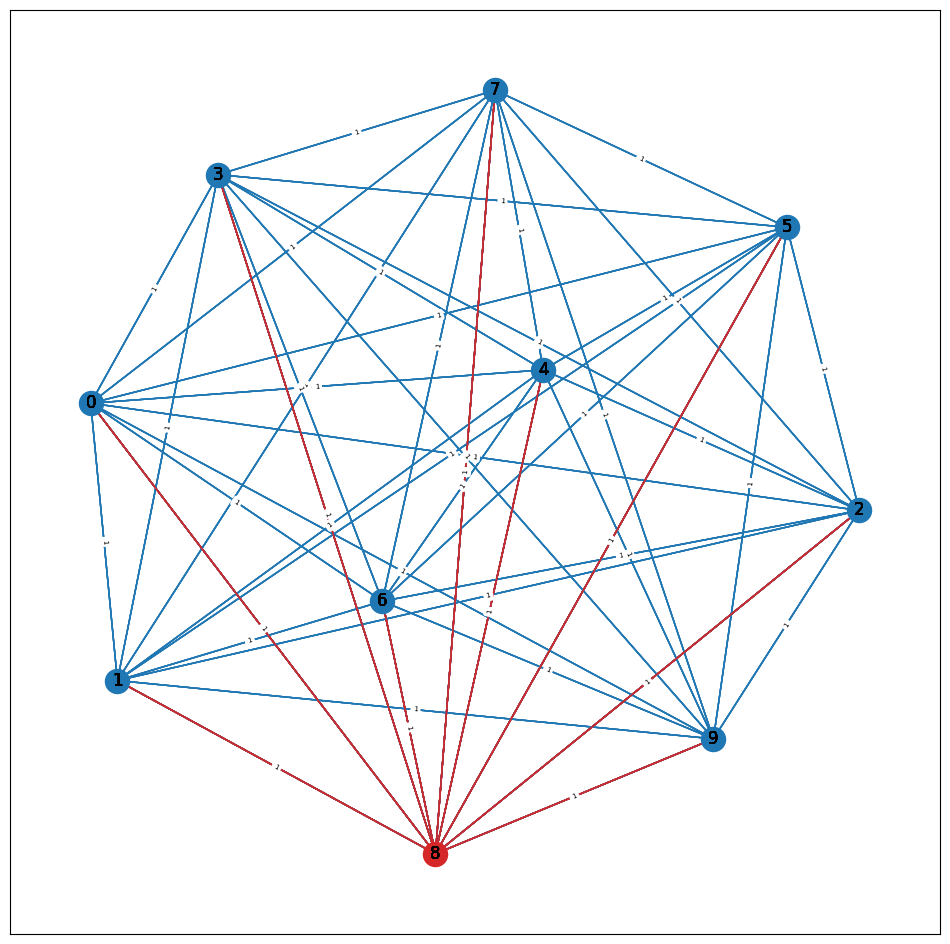

In [164]:
# Run this to view intial state of system
social_net, node_list, alive_nodes, edge_list, sus_edges = init_network(num_nodes=10)
draw_network(social_net, sus_edges)

### Parameters for the system

- $epochs$ is the number of iterations to run the model for. We can think of these timesteps as days for the sake of imagination.
- $alpha$ represents the imposter's anger level. It's used to increase the aggressive behaviour of imposter by having higher base chance of wanting to kill.
- $beta$ represents the rate at which the imposter will lose their patience. It is influenced by the time since last kill.
- $time\_since\_prev\_kill$ keeps track of the number of epochs that occur without a kill.
- $max\_dist$ is the maximum distance a node can move from its surroundings (this exists so we can normalize the avg distance)
- $invnorm\_dist$ is the average distance between all nodes, which we normalize and then invert so that when everyone is grouped up (avg_dist = 0) the imposter will be able to throw other people under suspicion better and therefore is more likely to kill.

In [165]:

#
def run_simulation(network: nx.Graph, alive_nodes: list, epochs, alpha, beta, max_dist):

    #Trust threshold is the level of trust an edge must have to cause its nodes to move either towards or away from eachother
    trust_threshold = 0.5
    time_since_prev_kill = 0
    t = 0
    
    # Compute average shortest path length of largest connected part of graph.
    Gcc = sorted(nx.connected_components(social_net), key=len, reverse=True)
    connected = social_net.subgraph(Gcc[0]) # largest component. Should always just be a single one.

    avg_dist = nx.average_shortest_path_length(connected, weight="distance")
    invnorm_dist = 1 - (avg_dist/ (max_dist))

    # Use while loop to iterate. Will exit after set epochs or if all other nodes have been killed.
    while alive_nodes and t < epochs:
        

        # # randomly update distances with slight bias to trusted nodes
        # for i in range(0, len(network.nodes)):
        #     # Since edges arent directed we only need to add edges from one node to another, not both ways
        #     for j in range(i, len(node_list)):
                
        #         # Check to ensure nodes are different to avoid self edges
        #         if i != j:
                    
        #             # Could make the distances scale with level of trust
        #             if network.edges[i, j]['trust'] > trust_threshold:
        #                 new_dist = random.randint(-3, 0)
        #                 network.edges[i, j]["distance"] = new_dist
        #             else:
        #                 new_dist = random.randint(0, 5)
        #                 network.edges[i, j]["distance"] = new_dist



        # random chance that imposter kills close by node
        kill_prob = invnorm_dist * alpha * beta * time_since_prev_kill

        # print(f"kill_prob = {kill_prob:.0%}%")

        # If probability of killing a node is greater than random float between 0-1
        if kill_prob > random.random():
        
            # choose node from alive subset
            chosen_node = random.choice(alive_nodes)
            alive_nodes.remove(chosen_node)
            
            # set node to deceased
            network.nodes[chosen_node[0]]["status"] = "dead"

            # Get all edges attached to killed node and then remove them
            dead_edges = [(chosen_node[0], n) for n in range(0, len(network.nodes))]
            network.remove_edges_from(dead_edges)

            # Remove edge from sus_edges list so that it isn't drawn. 
            # If bug from draw_network was fixed we could just delete this since everything would be assigned color based on its trust from other nodes
            #print(f"Removing node {chosen_node} at index: {chosen_node[0]} from list {sus_edges}")
            #sus_edges.pop(chosen_node[0])

            time_since_prev_kill = 0
            print(f"Killed node {chosen_node[0]} at time: {t} ")

        # if no kill was made increment time_since_prev_kill by 1
        time_since_prev_kill += 1
        t += 1

    print(f"Done!")


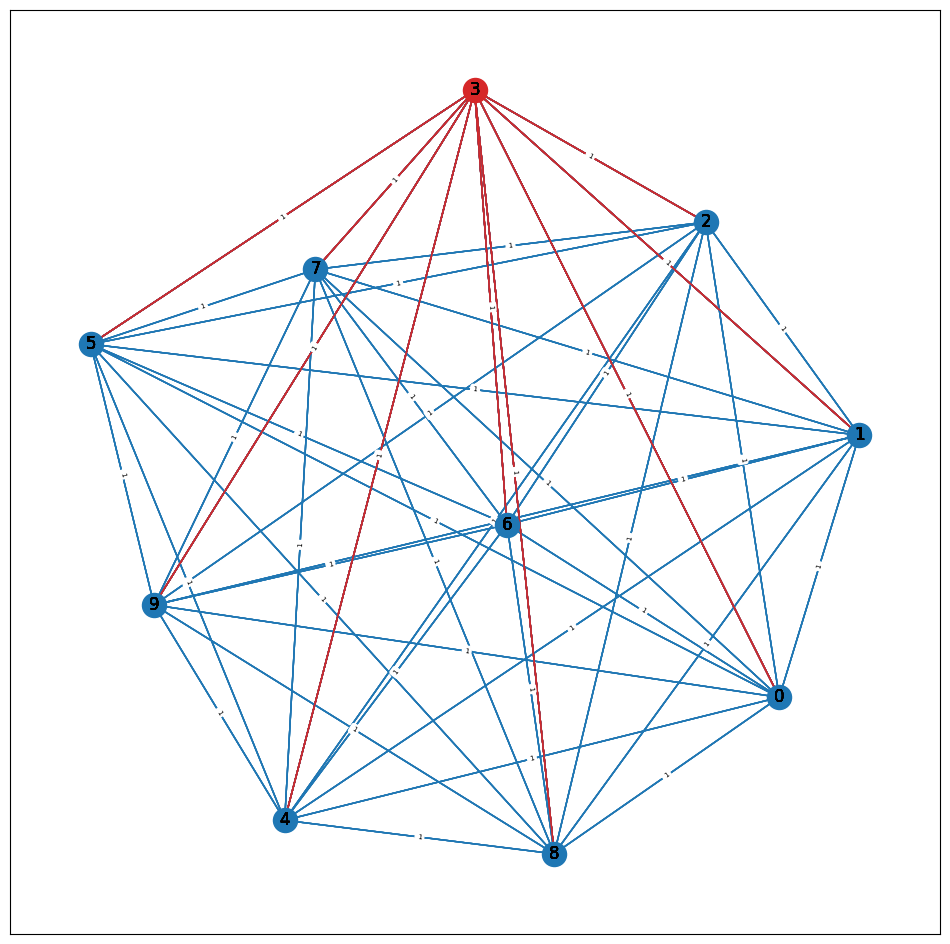

In [166]:
social_net, node_list, alive_nodes, edge_list, sus_edges = init_network(num_nodes=10)
draw_network(social_net, sus_edges)

# Gcc = sorted(nx.connected_components( social_net ), key=len, reverse=True)
# H = social_net.subgraph(Gcc[0]) # largest component

#print(nx.connected_components(social_net))
#c_nodes = [len(c) for c in sorted(nx.connected_components(social_net), key=len, reverse=True)]
#connected = social_net.subgraph(c_nodes)

Killed node 7 at time: 7 
Killed node 1 at time: 17 
Killed node 2 at time: 18 
Killed node 6 at time: 24 
Done!


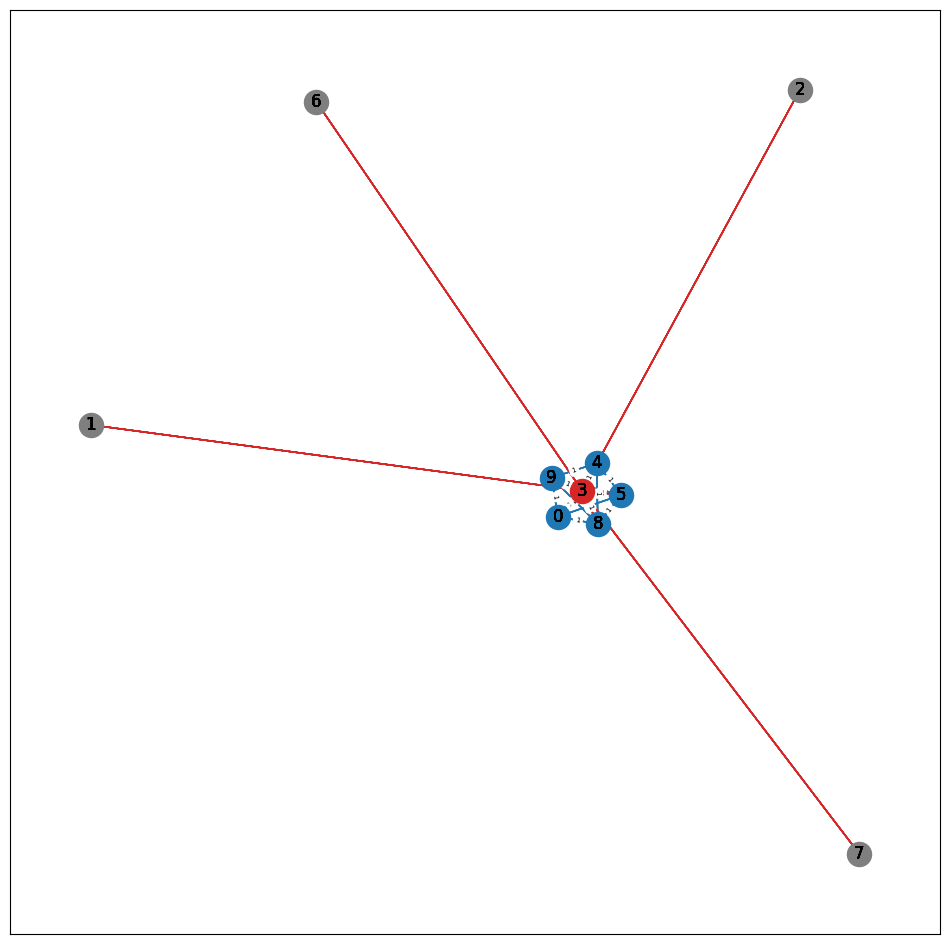

In [167]:
# Params: See above for explanations
epochs = 25
alpha = 0.5
beta = 0.1
max_dist = 20

run_simulation(social_net, alive_nodes, epochs, alpha, beta, max_dist)
draw_network(social_net, sus_edges)